In [1]:
!pip install lightgbm imbalanced-learn xgboost scikit-learn matplotlib seaborn

In [2]:
import pandas as pd


df = pd.read_csv("fraud_dataset.csv")
# Jumlah total data
print(f"Jumlah total data: {len(df)}")

# Jumlah per kelas (isFraud)
class_counts = df['isFraud'].value_counts()
print("\nJumlah data per kelas:")
print(class_counts)

Jumlah total data: 6362620

Jumlah data per kelas:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("fraud_dataset.csv")  

# Drop kolom identitas yang tidak informatif
df = df.drop(['nameOrig', 'nameDest'], axis=1)

# One-hot encode kolom 'type' (jenis transaksi)
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Pisahkan fitur dan label
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Normalisasi data numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


SMOTE

In [4]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# SMOTE Oversampling
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

print("Sebelum SMOTE:", Counter(y_train))
print("Setelah SMOTE:", Counter(y_resampled_smote))


Sebelum SMOTE: Counter({0: 5083526, 1: 6570})
Setelah SMOTE: Counter({0: 5083526, 1: 5083526})


UNDERSAMPLING

In [5]:
from imblearn.under_sampling import RandomUnderSampler

# Random undersampling
under = RandomUnderSampler(random_state=42)
X_resampled_under, y_resampled_under = under.fit_resample(X_train, y_train)

print("Setelah Undersampling:", Counter(y_resampled_under))


Setelah Undersampling: Counter({0: 6570, 1: 6570})


Cost-Sensitive Learning dengan XGBoost

In [6]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Rasio class
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Model dengan cost-sensitive learning
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


c:\Users\Ravicenna\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[1268991    1890]
 [     20    1623]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.46      0.99      0.63      1643

    accuracy                           1.00   1272524
   macro avg       0.73      0.99      0.81   1272524
weighted avg       1.00      1.00      1.00   1272524



Import Library

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns


Preprocessing Dataset

In [8]:
# Load dataset
df = pd.read_csv("fraud_dataset.csv")  # ganti nama file jika perlu

# Drop kolom non-numerik yang tidak informatif
df = df.drop(['nameOrig', 'nameDest'], axis=1)
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Fitur & Label
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split awal (nanti kita balancing setelah split)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [9]:
def preprocess_input(data_dict):
    df = pd.DataFrame([data_dict])

    # One-hot encoding manual untuk semua jenis 'type'
    df['type_CASH_OUT'] = 1 if df['type'].iloc[0] == 'CASH_OUT' else 0
    df['type_DEBIT'] = 1 if df['type'].iloc[0] == 'DEBIT' else 0
    df['type_PAYMENT'] = 1 if df['type'].iloc[0] == 'PAYMENT' else 0
    df['type_TRANSFER'] = 1 if df['type'].iloc[0] == 'TRANSFER' else 0

    df = df.drop('type', axis=1)

    # Urutkan kolom agar sesuai dengan urutan saat training
    df = df[feature_names]

    # Scaling
    df_scaled = scaler.transform(df)
    return df_scaled


Fungsi Balancing & Model Training + Evaluasi

In [10]:
def train_and_evaluate_models(X_train_res, y_train_res, X_test, y_test, label):
    models = {
        'LogReg': LogisticRegression(max_iter=1000),
        'RandomForest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LightGBM': LGBMClassifier()
    }

    results = {}

    print(f"\n========== [ {label.upper()} ] ==========\n")

    for name, model in models.items():
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        print(f"\n--- {name} ---")
        print(classification_report(y_test, y_pred, digits=4))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix - {name} ({label})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # ROC-AUC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

        results[name] = {
            'precision': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
            'recall': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
            'f1_score': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
            'roc_auc': round(auc, 4)
        }

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {label}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

    return results


Run SMOTE dan Undersampling

In [11]:
# SMOTE
smote = SMOTE(random_state=42)
X_res_smote, y_res_smote = smote.fit_resample(X_train, y_train)

# Undersampling
under = RandomUnderSampler(random_state=42)
X_res_under, y_res_under = under.fit_resample(X_train, y_train)


C:\Users\Ravicenna\AppData\Local\Temp\ipykernel_9720\988161592.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='isFraud', data=df, palette='Set2')


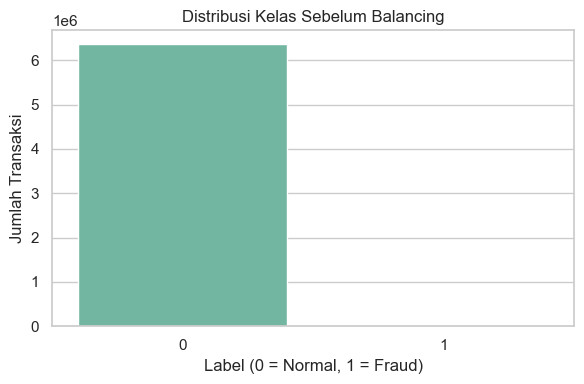

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Visualisasi distribusi kelas awal
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=df, palette='Set2')
plt.title("Distribusi Kelas Sebelum Balancing")
plt.xlabel("Label (0 = Normal, 1 = Fraud)")
plt.ylabel("Jumlah Transaksi")
plt.tight_layout()
plt.show()

C:\Users\Ravicenna\AppData\Local\Temp\ipykernel_9720\2820100340.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_res_smote, palette='Set1')


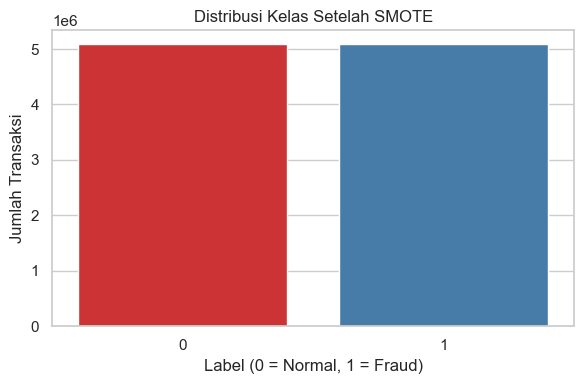

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_res_smote, palette='Set1')
plt.title("Distribusi Kelas Setelah SMOTE")
plt.xlabel("Label (0 = Normal, 1 = Fraud)")
plt.ylabel("Jumlah Transaksi")
plt.tight_layout()
plt.show()


C:\Users\Ravicenna\AppData\Local\Temp\ipykernel_9720\3645018238.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_res_under, palette='Set3')


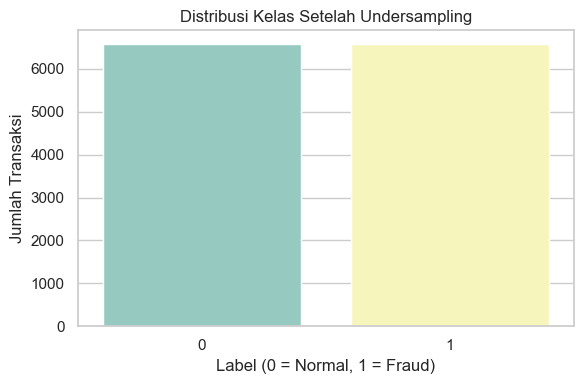

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_res_under, palette='Set3')
plt.title("Distribusi Kelas Setelah Undersampling")
plt.xlabel("Label (0 = Normal, 1 = Fraud)")
plt.ylabel("Jumlah Transaksi")
plt.tight_layout()
plt.show()


Latih dan Evaluasi Semua Model

In [15]:
def train_and_evaluate_models_quick_with_roc(X_train_res, y_train_res, X_test, y_test, label):
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    from sklearn.metrics import classification_report, roc_auc_score, roc_curve
    import matplotlib.pyplot as plt

    models = {
        'LogReg': LogisticRegression(max_iter=500),
        'RandomForest': RandomForestClassifier(n_estimators=20, max_depth=5, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=20, max_depth=3, use_label_encoder=False, eval_metric='logloss', verbosity=0),
        'LightGBM': LGBMClassifier(n_estimators=20, max_depth=3, random_state=42)
    }

    results = {}
    plt.figure(figsize=(8, 6))
    print(f"\n========== [ {label.upper()} - QUICK MODE + ROC ] ==========\n")

    for name, model in models.items():
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        print(f"\n--- {name} ---")
        print(classification_report(y_test, y_pred, digits=4))

        auc = roc_auc_score(y_test, y_prob)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")

        results[name] = {
            'precision': round(classification_report(y_test, y_pred, output_dict=True)['1']['precision'], 4),
            'recall': round(classification_report(y_test, y_pred, output_dict=True)['1']['recall'], 4),
            'f1_score': round(classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'], 4),
            'roc_auc': round(auc, 4)
        }

    # Finalize ROC plot
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {label}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results



========== [ SMOTE - QUICK MODE + ROC ] ==========


--- LogReg ---
              precision    recall  f1-score   support

           0     1.0000    0.9526    0.9757   1270881
           1     0.0261    0.9823    0.0508      1643

    accuracy                         0.9526   1272524
   macro avg     0.5130    0.9675    0.5133   1272524
weighted avg     0.9987    0.9526    0.9745   1272524


--- RandomForest ---
              precision    recall  f1-score   support

           0     1.0000    0.9588    0.9790   1270881
           1     0.0299    0.9817    0.0580      1643

    accuracy                         0.9589   1272524
   macro avg     0.5149    0.9703    0.5185   1272524
weighted avg     0.9987    0.9589    0.9778   1272524


--- XGBoost ---
              precision    recall  f1-score   support

           0     1.0000    0.9742    0.9869   1270881
           1     0.0475    0.9951    0.0906      1643

    accuracy                         0.9742   1272524
   macro avg     0.5

c:\Users\Ravicenna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Ravicenna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- LightGBM ---
              precision    recall  f1-score   support

           0     1.0000    0.9543    0.9766   1270881
           1     0.0272    0.9909    0.0530      1643

    accuracy                         0.9543   1272524
   macro avg     0.5136    0.9726    0.5148   1272524
weighted avg     0.9987    0.9543    0.9754   1272524



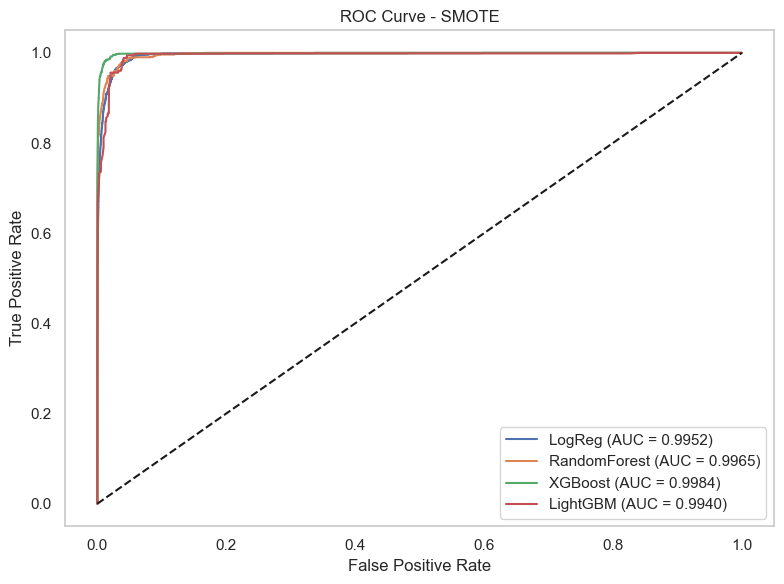


========== [ UNDERSAMPLING - QUICK MODE + ROC ] ==========


--- LogReg ---
              precision    recall  f1-score   support

           0     0.9999    0.9295    0.9634   1270881
           1     0.0168    0.9337    0.0331      1643

    accuracy                         0.9295   1272524
   macro avg     0.5084    0.9316    0.4982   1272524
weighted avg     0.9986    0.9295    0.9622   1272524


--- RandomForest ---
              precision    recall  f1-score   support

           0     1.0000    0.9604    0.9798   1270881
           1     0.0309    0.9757    0.0599      1643

    accuracy                         0.9604   1272524
   macro avg     0.5154    0.9680    0.5198   1272524
weighted avg     0.9987    0.9604    0.9786   1272524


--- XGBoost ---
              precision    recall  f1-score   support

           0     1.0000    0.9781    0.9889   1270881
           1     0.0553    0.9927    0.1048      1643

    accuracy                         0.9781   1272524
   macro avg

c:\Users\Ravicenna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Ravicenna\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- LightGBM ---
              precision    recall  f1-score   support

           0     1.0000    0.9549    0.9769   1270881
           1     0.0272    0.9750    0.0530      1643

    accuracy                         0.9550   1272524
   macro avg     0.5136    0.9650    0.5149   1272524
weighted avg     0.9987    0.9550    0.9757   1272524



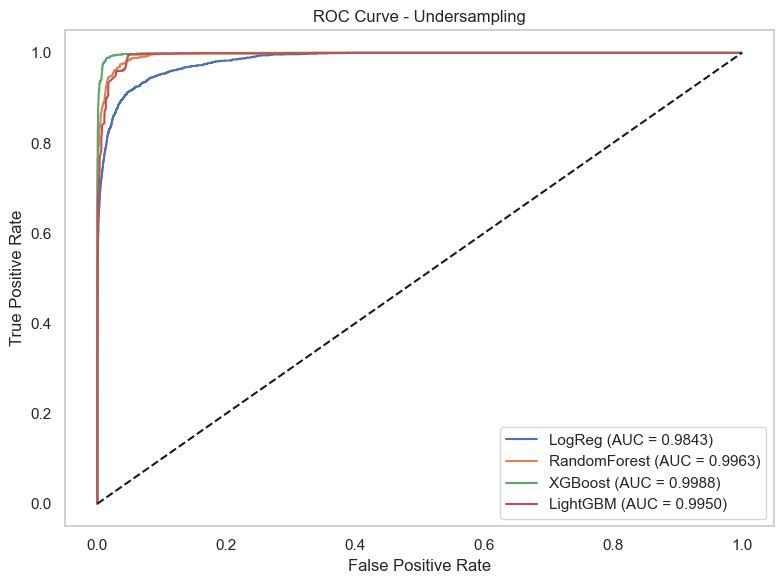

In [16]:
results_smote_quick = train_and_evaluate_models_quick_with_roc(X_res_smote, y_res_smote, X_test, y_test, "SMOTE")
results_under_quick = train_and_evaluate_models_quick_with_roc(X_res_under, y_res_under, X_test, y_test, "Undersampling")


PERBANDINGANYA

In [17]:
pd.DataFrame({
    'SMOTE_Quick': results_smote_quick,
    'Under_Quick': results_under_quick
}).T


,LogReg,RandomForest,XGBoost,LightGBM
SMOTE_Quick,"{'precision': 0.0261, 'recall': 0.9823, 'f1_sc...","{'precision': 0.0299, 'recall': 0.9817, 'f1_sc...","{'precision': 0.0475, 'recall': 0.9951, 'f1_sc...","{'precision': 0.0272, 'recall': 0.9909, 'f1_sc..."
Under_Quick,"{'precision': 0.0168, 'recall': 0.9337, 'f1_sc...","{'precision': 0.0309, 'recall': 0.9757, 'f1_sc...","{'precision': 0.0553, 'recall': 0.9927, 'f1_sc...","{'precision': 0.0272, 'recall': 0.975, 'f1_sco..."


In [18]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res_smote, y_res_smote = smote.fit_resample(X_train, y_train)


In [19]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, max_depth=4, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_res_smote, y_res_smote)


c:\Users\Ravicenna\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:18:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
import joblib

In [21]:
joblib.dump(xgb_model, "xgb_model_smote.pkl")

['xgb_model_smote.pkl']

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X adalah dataframe hasil preprocessing


In [23]:
#simpan scaler untuk normalisasi data
import joblib
joblib.dump(scaler, "scaler.pkl")


# Simpan nama fitur yang digunakan saat training
joblib.dump(X.columns.tolist(), "feature_names.pkl")



['feature_names.pkl']